# 네이버 영화 리뷰

In [208]:
!pip install --upgrade pip==21.2.3 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [209]:
!pip install --upgrade gensim==3.8.3 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [210]:
from gensim.models import KeyedVectors
import gensim

In [211]:
gensim.__version__

'3.8.3'

In [212]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os

In [213]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2021-10-04 12:05:54--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.6’

ratings_train.txt.6 100%[===================>]  13.95M  --.-KB/s    in 0.1s    

2021-10-04 12:05:54 (121 MB/s) - ‘ratings_train.txt.6’ saved [14628807/14628807]



In [214]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2021-10-04 12:05:55--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt.6’

ratings_test.txt.6  100%[===================>]   4.67M  --.-KB/s    in 0.06s   

2021-10-04 12:05:55 (75.0 MB/s) - ‘ratings_test.txt.6’ saved [4893335/4893335]



In [215]:
train_data = pd.read_table('~/aiffel/ratings_train.txt')
test_data = pd.read_table('~/aiffel/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [216]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [217]:
len(train_data)

150000

In [218]:
len(test_data)

50000

In [219]:
train_docs = list(train_data['document'])

In [220]:
test_docs = list(test_data['document'])

In [221]:
docs = train_docs + test_docs
docs[:5]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']

In [222]:
# 중복 제거
unique_corpus = list(set(docs)) 
len(cleaned_corpus )

194543

In [223]:
# ???
type(unique_corpus[0])

float

In [224]:
unique_corpus = list(map(str, cleaned_corpus))
unique_corpus[:5]

['어두워서 좋았음',
 '사랑스러운 내용',
 '이건 머 2시간 짜릴 중후반까지 병맛 멜로 스토리도 아니구 찌질이 범생같은 주연을 이소룡 카리스마를 대변하겠다는 발상이 저승에서 하데스랑 친구하는 싱하형 알면 감독 조낸 쳐 맞을듯',
 '이 드라마 언제 끝나요 이건 아침부터 너무 불쾌한 완전 막장 드라마 인데 빨리 끝내고 아침에 기분좋게 하루를 시작할수 있는 드라마를 볼수있게 해주세요',
 '시궁창 같은시대의 보석 같은 다큐']

In [225]:
#unique_corpus.remove('nan')

In [226]:
# 한국어 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  #sentence = re.sub(r"([?.!,])", " ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  sentence = re.sub(r"[^0-9가-힣]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [227]:
cleaned_corpus = list(map(preprocess_sentence, unique_corpus))
cleaned_corpus[:5]

['어두워서 좋았음',
 '사랑스러운 내용',
 '이건 머 2시간 짜릴 중후반까지 병맛 멜로 스토리도 아니구 찌질이 범생같은 주연을 이소룡 카리스마를 대변하겠다는 발상이 저승에서 하데스랑 친구하는 싱하형 알면 감독 조낸 쳐 맞을듯',
 '이 드라마 언제 끝나요 이건 아침부터 너무 불쾌한 완전 막장 드라마 인데 빨리 끝내고 아침에 기분좋게 하루를 시작할수 있는 드라마를 볼수있게 해주세요',
 '시궁창 같은시대의 보석 같은 다큐']

In [228]:
import sentencepiece as spm
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/NSMC.train.ko.temp'

vocab_size = 8000

# 이전 Step에서 중복을 제거한 문장들을 선택한 코퍼스를 저장 
with open(temp_file, 'w') as f:
    for row in cleaned_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=NSMC_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l NSMC_spm*

-rw-r--r-- 1 root root 378316 Oct  4 12:06 NSMC_spm.model
-rw-r--r-- 1 root root 147807 Oct  4 12:06 NSMC_spm.vocab


In [229]:
s = spm.SentencePieceProcessor()
s.Load('NSMC_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))  # nbest_size (unigram sampling parameter), alpha
# The “nbest” parameter allows you to select from more segmentation options. The higher the parameter, the more options will be considered.

# ?? 
# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1192, 9, 376, 12, 1212, 9, 135, 13, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [234]:
corpusNum = [len(i.split()) for i in cleaned_corpus]
corpusNum[:5]

[2, 2, 25, 22, 5]

In [235]:
numList = np.array(corpusNum)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(numList))
print('문장길이 최대 : ', np.max(numList))
print('문장길이 표준편차 : ', np.std(numList))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(numList) + 2 * np.std(numList)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(numList < max_tokens) / len(numList)))

문장길이 평균 :  7.903692242846055
문장길이 최대 :  47
문장길이 표준편차 :  6.694803379713627
pad_sequences maxlen :  21
전체 문장의 0.9372169648869402%가 maxlen 설정값 이내에 포함됩니다. 


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


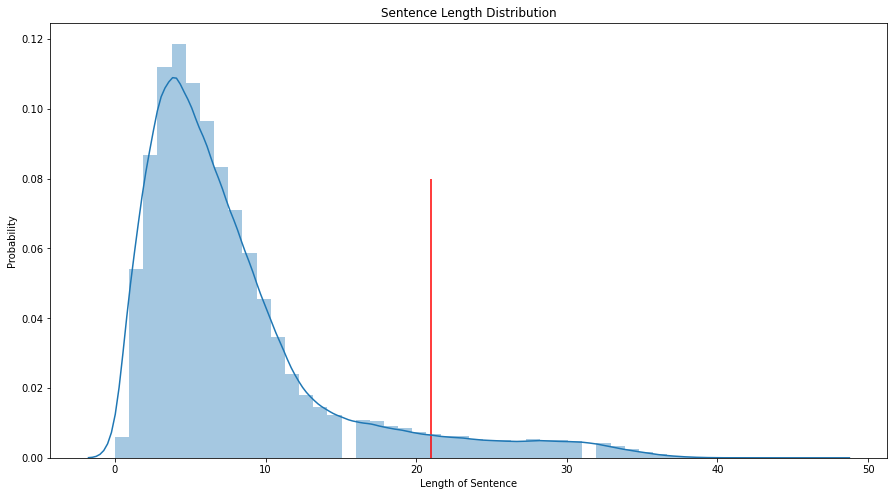

In [236]:
f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(a= numList, ax=ax)
plt.xlabel('Length of Sentence')
plt.ylabel('Probability')
plt.title('Sentence Length Distribution')
plt.vlines(21, 0,0.08, colors= 'red')
plt.show()

In [240]:
selected_corpus = []
for i in range(len(cleaned_corpus)):
    if corpusNum[i] > 21 :
        continue
    else :
        selected_corpus.append(cleaned_corpus[i])

selected_corpus[:5]

['어두워서 좋았음',
 '사랑스러운 내용',
 '시궁창 같은시대의 보석 같은 다큐',
 '똥덩어리를 오줌에 비벼먹는 느낌의 영화',
 '진심이거 어옼']

In [241]:
len(selected_corpus)

182329

In [242]:
dir(s)

['Decode',
 'DecodeIds',
 'DecodeIdsAsSerializedProto',
 'DecodeIdsAsSerializedProtoWithCheck',
 'DecodeIdsWithCheck',
 'DecodePieces',
 'DecodePiecesAsSerializedProto',
 'Detokenize',
 'Encode',
 'EncodeAsIds',
 'EncodeAsPieces',
 'EncodeAsSerializedProto',
 'GetEncoderVersion',
 'GetPieceSize',
 'GetScore',
 'IdToPiece',
 'Init',
 'IsByte',
 'IsControl',
 'IsUnknown',
 'IsUnused',
 'Load',
 'LoadFromFile',
 'LoadFromSerializedProto',
 'LoadVocabulary',
 'NBestEncodeAsIds',
 'NBestEncodeAsPieces',
 'NBestEncodeAsSerializedProto',
 'PieceToId',
 'ResetVocabulary',
 'SampleEncodeAsIds',
 'SampleEncodeAsPieces',
 'SampleEncodeAsSerializedProto',
 'SetDecodeExtraOptions',
 'SetEncodeExtraOptions',
 'SetEncoderVersion',
 'SetVocabulary',
 'Tokenize',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '_

In [253]:
def sp_tokenize(s, corpus): # corpus : 문장들로 구성된 Corpus

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))  # 자연어 형태를 word_index에 따라, 해당하는 숫자 값으로 변환

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines() # 문장들로 구성된 List 형태로 읽어들임

    word_index = {} 
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0] 

        index_word.update({idx:word})  #!!! Dict.update()
        word_index.update({word:idx})

    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=21)

    return tensor, word_index, index_word

In [262]:
tensor, word_index, index_word = sp_tokenize(s, selected_corpus)

In [263]:
len(tensor[0])

21

In [264]:
tensor[1]

array([2967,  250,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [265]:
selected_corpus[1]

'사랑스러운 내용'

In [266]:
index_word[0]

'<unk>'

In [267]:
index_word[1]

'<s>'

In [268]:
index_word[2]

'</s>'

In [294]:
def preprocess(df):
  df = df.dropna()
  df = df.drop_duplicates(["document"])
  df["document"] = df['document'].map(lambda x: preprocess_sentence(x))
  df['document_len']  = df['document'].map(lambda x: len(x.split()))
  del_idx =  df[df['document_len'] < 22].index
  df = df.drop(del_idx)
  df = df.drop(['document_len'],axis = 1)
  df.reset_index(drop = True, inplace = True)
  return df

In [295]:
def load_data(s):
  train_data_path = "~/aiffel/ratings_train.txt"
  test_data_path = "~/aiffel/ratings_test.txt"

  train_data = pd.read_csv(train_data_path, sep="\t")
  test_data = pd.read_csv(test_data_path, sep="\t")
  print( f'original train_data:{len(train_data)}, test_data:{len(test_data)}' )


  train_data = preprocess(train_data)
  test_data = preprocess(test_data)
  print( f'cleaned train_data:{len(train_data)}, test_data:{len(test_data)}' )

  X_train = train_data["document"]
  y_train = train_data["label"]
  X_test = test_data["document"]
  y_test = test_data["label"]

  print("\nSuccess!")
  print(f"Train data sample : [{y_train[100]}] {X_train[100]}")
  print(f"Test data sample : [{y_test[100]}] {X_test[100]}")

  print("\nencoding..")
  X_train, word_index, index_word = sp_tokenize(s, X_train)
  X_test, _, _ = sp_tokenize(s, X_test)
  print(f"Train data sample : [{y_train[100]}]\n\t{X_train[100].tolist()}\n\t{s.DecodeIds(X_train[100].tolist())}")
  print(f"Test data sample : [{y_test[100]}]\n\t{X_test[100].tolist()}\n\t{s.DecodeIds(X_test[100].tolist())}")

  return X_train, y_train, X_test, y_test, word_index, index_word

In [296]:
s = spm.SentencePieceProcessor()
s.Load('NSMC_spm.model')
X_train, y_train, X_test, y_test, word_index, index_word = load_data(s)

original train_data:150000, test_data:50000
cleaned train_data:9128, test_data:3090

Success!
Train data sample : [0] 요즘은함께하는거본다 옴니버스식이던데 그러기엔 가족이넘 많아요 머좀 빠져들려면 바뀌고바뀌고 전 시즌1부터 오로지 윤후 보려고보는데 점점 산만해지는 느낌이예요 우리 윤후 분량좀 많이많이 늘려주세요 너무착하고예쁜 후
Test data sample : [1] 일본 영화다운 영화 보는 내내 힐링되었네요 잠시나마 도시를 벗어나 자연속에서 함께 시간을 보내고 온것 같았습니다 뽀너스로 손수 만드는 건강한 일본 집밥 보는 내내 배가 고팠다는 슬픔이

encoding..
Train data sample : [0]
	[1126, 21, 1491, 781, 1316, 437, 1230, 478, 5745, 262, 157, 1910, 1823, 144, 1617, 17, 2205, 38, 696, 3829, 336]
	산만해지는 느낌이예요 우리 윤후 분량좀 많이많이 늘려주세요 너무착하고예쁜 후
Test data sample : [1]
	[64, 23, 1001, 68, 450, 6836, 16, 272, 1380, 3680, 129, 394, 603, 9, 3, 11, 7973, 13, 7, 2297, 4]
	스로 손수 만드는 건강한 일본 집밥 보는 내내 배가 고팠다는 슬픔이


In [297]:
len(X_train)

9128

In [298]:
len(y_train)

9128

In [299]:
len(X_test)

3090

In [300]:
len(y_test)

3090

# 모델 학습

# 모델구성 및 Validation Set 구성 

In [305]:
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_1 = keras.Sequential()

model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.LSTM(8)) # LSTM Layer의 Input Vector (a,b) : a는 timestep의 갯수, b는 feature들    
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         1600000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,606,769
Trainable params: 1,606,769
Non-trainable params: 0
_________________________________________________________________


In [306]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print( f'train_data:{len(X_train)}, val_data:{len(X_val)}, test_data:{len(X_test)}' )

train_data:5841, val_data:1461, test_data:3090


# 모델_1 (LSTM)

In [308]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_1 = model_1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
12/12 [==============================] - 3s 62ms/step - loss: 0.6905 - accuracy: 0.5495 - val_loss: 0.6781 - val_accuracy: 0.5756
Epoch 2/20
12/12 [==============================] - 0s 21ms/step - loss: 0.6657 - accuracy: 0.6049 - val_loss: 0.6508 - val_accuracy: 0.6804
Epoch 3/20
12/12 [==============================] - 0s 21ms/step - loss: 0.6159 - accuracy: 0.7295 - val_loss: 0.6077 - val_accuracy: 0.7331
Epoch 4/20
12/12 [==============================] - 0s 21ms/step - loss: 0.5426 - accuracy: 0.8149 - val_loss: 0.5582 - val_accuracy: 0.7803
Epoch 5/20
12/12 [==============================] - 0s 21ms/step - loss: 0.4523 - accuracy: 0.8862 - val_loss: 0.5145 - val_accuracy: 0.7906
Epoch 6/20
12/12 [==============================] - 0s 21ms/step - loss: 0.3433 - accuracy: 0.9325 - val_loss: 0.4976 - val_accuracy: 0.7693
Epoch 7/20
12/12 [==============================] - 0s 21ms/step - loss: 0.2341 - accuracy: 0.9637 - val_loss: 0.5189 - val_accuracy: 0.7645
Epoch 8/20
12

In [309]:
results_1 = model_1.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_1)

97/97 - 0s - loss: 1.2107 - accuracy: 0.6981
[1.2106661796569824, 0.6980582475662231]


In [310]:
history_1.history

{'loss': [0.6885608434677124,
  0.6593685150146484,
  0.6073269248008728,
  0.5298541188240051,
  0.4337575435638428,
  0.32648593187332153,
  0.2230193018913269,
  0.14946109056472778,
  0.10136402398347855,
  0.07225339859724045,
  0.056042641401290894,
  0.04503687098622322,
  0.03754755109548569,
  0.031375106424093246,
  0.02738911658525467,
  0.023310622200369835,
  0.020295940339565277,
  0.01800583489239216,
  0.015868481248617172,
  0.014514012262225151],
 'accuracy': [0.5469954013824463,
  0.6269474625587463,
  0.7366889119148254,
  0.8301660418510437,
  0.8894025087356567,
  0.9344290494918823,
  0.9643896818161011,
  0.9780859351158142,
  0.9863036870956421,
  0.992124617099762,
  0.9940078854560852,
  0.9953774809837341,
  0.9958910942077637,
  0.9964047074317932,
  0.9965759515762329,
  0.9972607493400574,
  0.997603178024292,
  0.9979455471038818,
  0.9981167316436768,
  0.9981167316436768],
 'val_loss': [0.6781425476074219,
  0.6508314609527588,
  0.6077069640159607,
  

# Loss 시각화

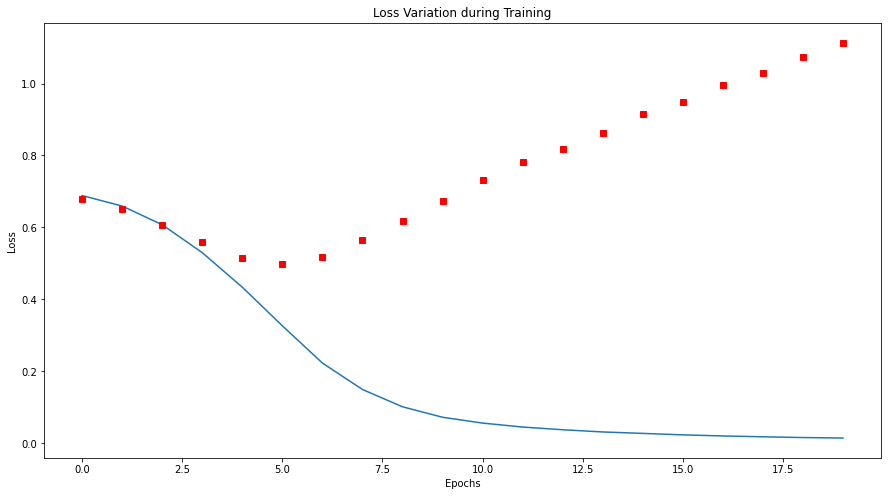

In [311]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

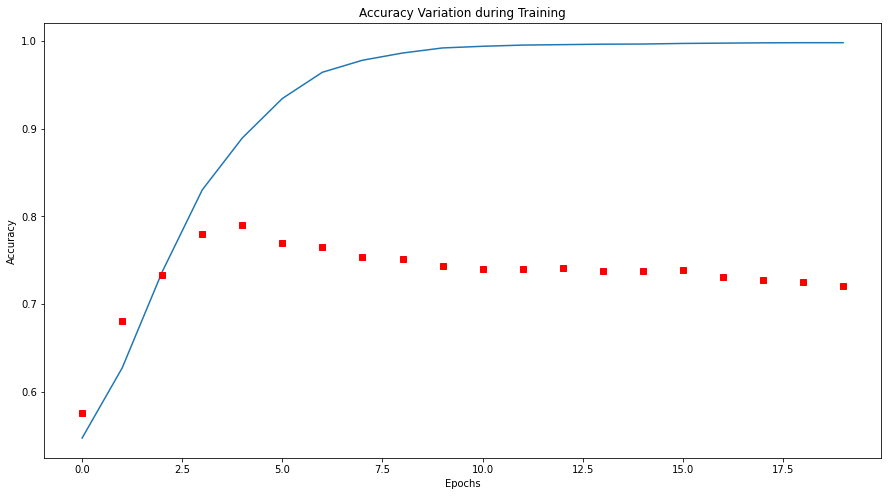

In [312]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

# 모델_2 (GRU)

In [314]:
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_2 = keras.Sequential()

model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.GRU(8))    
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         1600000   
_________________________________________________________________
gru (GRU)                    (None, 8)                 5040      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,605,121
Trainable params: 1,605,121
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련 개시

In [315]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_2 = model_2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
12/12 [==============================] - 2s 75ms/step - loss: 0.6906 - accuracy: 0.5408 - val_loss: 0.6824 - val_accuracy: 0.5510
Epoch 2/20
12/12 [==============================] - 0s 20ms/step - loss: 0.6722 - accuracy: 0.5419 - val_loss: 0.6679 - val_accuracy: 0.5530
Epoch 3/20
12/12 [==============================] - 0s 21ms/step - loss: 0.6448 - accuracy: 0.5619 - val_loss: 0.6488 - val_accuracy: 0.6208
Epoch 4/20
12/12 [==============================] - 0s 20ms/step - loss: 0.5964 - accuracy: 0.7008 - val_loss: 0.6300 - val_accuracy: 0.6626
Epoch 5/20
12/12 [==============================] - 0s 21ms/step - loss: 0.5464 - accuracy: 0.7756 - val_loss: 0.6187 - val_accuracy: 0.6865
Epoch 6/20
12/12 [==============================] - 0s 21ms/step - loss: 0.4937 - accuracy: 0.8434 - val_loss: 0.6132 - val_accuracy: 0.6913
Epoch 7/20
12/12 [==============================] - 0s 21ms/step - loss: 0.4380 - accuracy: 0.8830 - val_loss: 0.6128 - val_accuracy: 0.7036
Epoch 8/20
12

In [316]:
results_2 = model_2.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_2)

97/97 - 0s - loss: 1.0253 - accuracy: 0.6964
[1.0252548456192017, 0.6964401006698608]


In [317]:
history_2.history

{'loss': [0.68944251537323,
  0.6694502830505371,
  0.6372072696685791,
  0.5921880006790161,
  0.5388259291648865,
  0.48383450508117676,
  0.4306924343109131,
  0.37928506731987,
  0.32951125502586365,
  0.2811554968357086,
  0.23576927185058594,
  0.19494420289993286,
  0.15907329320907593,
  0.12842300534248352,
  0.10255327075719833,
  0.08306225389242172,
  0.06841130554676056,
  0.056944333016872406,
  0.04874458163976669,
  0.04244042932987213],
 'accuracy': [0.5377503633499146,
  0.537236750125885,
  0.5949323773384094,
  0.7062146663665771,
  0.7846259474754333,
  0.8447183966636658,
  0.8849512338638306,
  0.9159390330314636,
  0.9349426627159119,
  0.9570279121398926,
  0.9676425457000732,
  0.9772299528121948,
  0.9827084541320801,
  0.9861325025558472,
  0.9892141819000244,
  0.9914398193359375,
  0.9929806590080261,
  0.9938367009162903,
  0.9946926832199097,
  0.9948638677597046],
 'val_loss': [0.682425856590271,
  0.6678658127784729,
  0.6488167643547058,
  0.629985690

# Loss 시각화

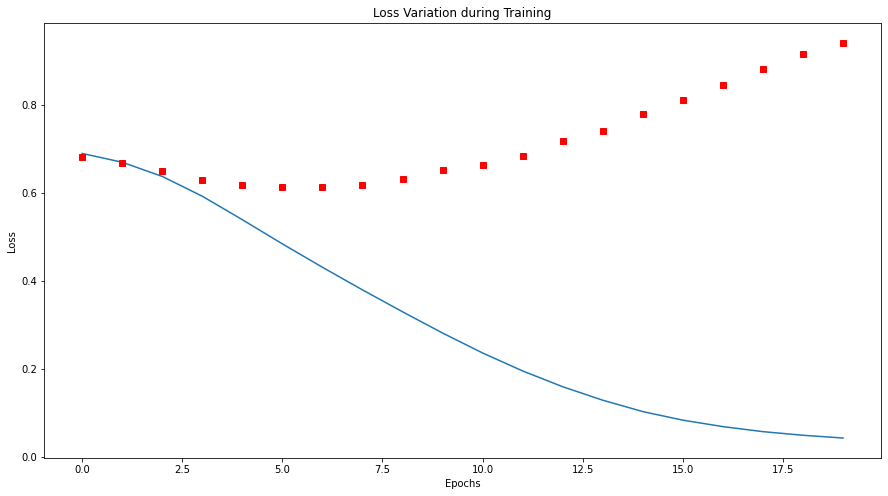

In [318]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

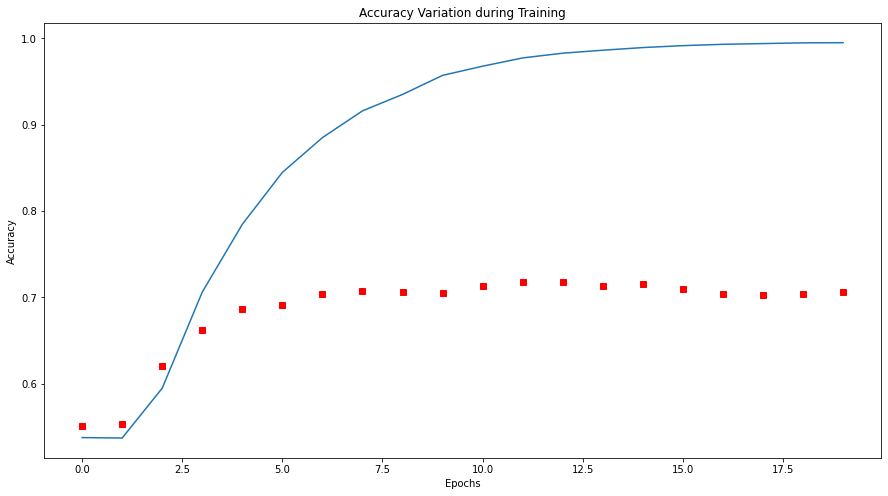

In [319]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()

# 모델_3 (LSTM * 2)

In [321]:
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원 수 

# model 설계 
model_3 = keras.Sequential()

model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.LSTM(8,return_sequences = True))
model_3.add(keras.layers.LSTM(8))
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         1600000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 8)           6688      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,607,313
Trainable params: 1,607,313
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련 개시

In [323]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_3 = model_3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
12/12 [==============================] - 4s 88ms/step - loss: 0.6912 - accuracy: 0.5390 - val_loss: 0.6815 - val_accuracy: 0.5524
Epoch 2/20
12/12 [==============================] - 0s 26ms/step - loss: 0.6728 - accuracy: 0.5570 - val_loss: 0.6546 - val_accuracy: 0.6386
Epoch 3/20
12/12 [==============================] - 0s 26ms/step - loss: 0.6255 - accuracy: 0.6943 - val_loss: 0.6034 - val_accuracy: 0.7146
Epoch 4/20
12/12 [==============================] - 0s 26ms/step - loss: 0.5411 - accuracy: 0.7995 - val_loss: 0.5559 - val_accuracy: 0.7789
Epoch 5/20
12/12 [==============================] - 0s 26ms/step - loss: 0.4381 - accuracy: 0.8923 - val_loss: 0.5554 - val_accuracy: 0.7604
Epoch 6/20
12/12 [==============================] - 0s 26ms/step - loss: 0.3437 - accuracy: 0.9441 - val_loss: 0.5838 - val_accuracy: 0.7488
Epoch 7/20
12/12 [==============================] - 0s 26ms/step - loss: 0.2621 - accuracy: 0.9609 - val_loss: 0.6102 - val_accuracy: 0.7379
Epoch 8/20
12

In [324]:
results_3 = model_3.evaluate(X_test,  y_test, verbose=2) # Loss 값 반환

print(results_3)

97/97 - 0s - loss: 1.2673 - accuracy: 0.6861
[1.2672724723815918, 0.6860841512680054]


In [325]:
history_3.history

{'loss': [0.6896072030067444,
  0.6666767597198486,
  0.612689197063446,
  0.5234949588775635,
  0.4235653281211853,
  0.33053648471832275,
  0.24678592383861542,
  0.18545901775360107,
  0.14290191233158112,
  0.11375045776367188,
  0.09099822491407394,
  0.07622408866882324,
  0.06586737185716629,
  0.05855043604969978,
  0.05528835952281952,
  0.04868030175566673,
  0.0447048544883728,
  0.04118511453270912,
  0.03911043331027031,
  0.03576185926795006],
 'accuracy': [0.5374079942703247,
  0.5803800821304321,
  0.7086115479469299,
  0.8174970149993896,
  0.9019003510475159,
  0.9436740279197693,
  0.9635336399078369,
  0.9727786183357239,
  0.9785995483398438,
  0.9825372099876404,
  0.9864749312400818,
  0.9881869554519653,
  0.9892141819000244,
  0.9904125928878784,
  0.9905837774276733,
  0.9917822480201721,
  0.992124617099762,
  0.993151843547821,
  0.9934942722320557,
  0.9940078854560852],
 'val_loss': [0.681526780128479,
  0.6546200513839722,
  0.6033716797828674,
  0.555912

# Loss 시각화

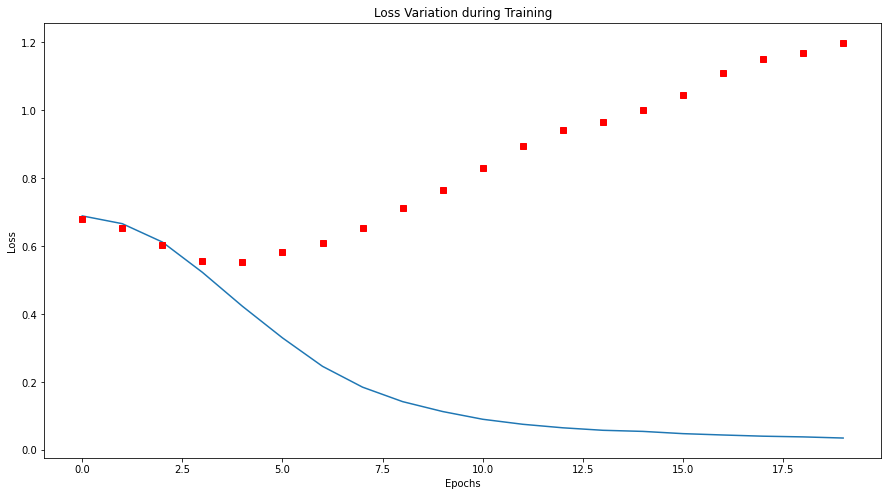

In [326]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation during Training')
plt.show()

# Accuracy 시각화

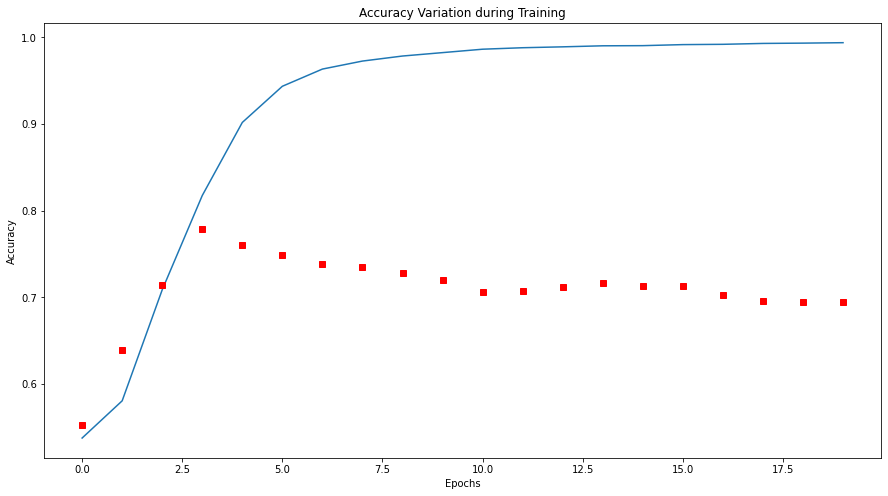

In [327]:
f,ax = plt.subplots(1,1, figsize=(15,8))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'],'rs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Variation during Training')
plt.show()